In [1]:
library(tidyverse)  
library(lubridate)
library(dplyr)
library(readr)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# ***Title: How To Get More Players***

- Woobin Kim (39017496)

- Jinze Deng (75628784)

- Elvis Cheung (46937033)

Analyzing user data has become increasingly important in today’s gaming industry. By collecting and analyzing players data, we can identify ***which "kinds" of players*** are most likely to contribute a large amount of data.  This insight allows us to better target those players in our recruiting efforts — and this is the primary goal of our project.

To achieve this, we developed and explored four key questions:
1. Relation between "age" and engagement level metrics  
    > ***Do older players spend more time per session? (age vs average session duration)***

2. Relation between "experience" and engagement level metrics  
    > ***Do players with more experience tend to play more? (experience vs Average Played Hours)***

3. Relation between "gender" and engagement level metrics  
    > ***Which gender has more sessions? (gender vs total sessions)***

4. Relation between "subscription" and engagement level metrics  
    > ***Do subscribers tend to play more than non-subscribers? (subscribe vs total play time)***

The datasets used for this analysis include personal information of players from a specific game platform, along with detailed records of their play sessions. ***We merged two datasets (players.csv, sessions.csv) using the players' email addresses as a common key.*** The variables in the merged dataset include age, gender, experience, subscription status, name, hashed email, total play hours, session start time, and end time. Based on these variables, we performed various calculations and comparisons to answer our research questions.



### **Data** 

In [2]:
players <- read_csv("https://raw.githubusercontent.com/Elvis614412/Dsci-100-group-project/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/Elvis614412/Dsci-100-group-project/refs/heads/main/sessions.csv")

merged_data <- left_join(players,sessions, by = "hashedEmail")

merged_data <- merged_data|>
    select(-hashedEmail,-original_start_time,-original_end_time)
    merged_data$Age[is.na(merged_data$Age)] <- mean(merged_data$Age, na.rm = TRUE)

head(merged_data, 5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,name,gender,Age,start_time,end_time
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
Pro,TRUE,30.3,Morgan,Male,9,08/08/2024 00:21,08/08/2024 01:35
Pro,TRUE,30.3,Morgan,Male,9,09/09/2024 22:30,09/09/2024 22:37
Pro,TRUE,30.3,Morgan,Male,9,08/08/2024 02:41,08/08/2024 03:25
Pro,TRUE,30.3,Morgan,Male,9,10/09/2024 15:07,10/09/2024 15:29
Pro,TRUE,30.3,Morgan,Male,9,05/05/2024 22:21,05/05/2024 23:17


## ***Q1. Do older players spend more time per session? (age vs average session duration)***

In [3]:
merged_data <- merged_data|>
    mutate(
        start_time = as.POSIXct(start_time, format = "%m/%d/%Y %H:%M"),
        end_time = as.POSIXct(end_time, format = "%m/%d/%Y %H:%M"),
        session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
    )

name_order <- merged_data |>
  count(name, sort = TRUE) |>
  pull(name)

merged_data$name <- factor(merged_data$name, levels = name_order)

merged_data <- merged_data |>
  arrange(name,start_time)

# merged_data <- merged_data |>
#     filter(name == "Morgan") |>
#     arrange(start_time)

merged_data_clean <- merged_data |>
  filter(session_duration <= 1440 ,!is.na(start_time),!is.na(end_time))

merged_data2 <- merged_data_clean |> 
    group_by(name,Age,experience,subscribe) |>
    summarize(average_playtime = mean(session_duration),.groups = "drop")

merged_data2 <- merged_data2 |>
    select(-name,-experience,-subscribe)

merged_data2 <- merged_data2 |>
    mutate(
        Age = as.integer(Age),
        average_playtime = round(average_playtime,2)
    ) |>
    arrange(Age)

average_by_age <- merged_data2|> 
    group_by(Age) |>
    summarize(average_playtime = mean(average_playtime),.groups = "drop")

average_by_age <- average_by_age |> 
    mutate(
        average_playtime = round(average_playtime)
    )

head(average_by_age,5)



Age,average_playtime
<int>,<dbl>
9,57
10,17
11,18
12,34
14,20


To calculate the average playtime per session, the start_time and end_time variables were first converted from factors to appropriate time formats. 

Before performing the calculation, **I identified the outliers represented non-overlapping, extremely long sessions** and were unlikely to affect the analysis.

**The outliers were extremly long sessions which is saying that some player played almost a month**. I pick specific player "Morgan" who appeared to have played for nearly a month, and I confirmed that this was due to erroneous data. **A few other players also exhibited similar issues**. To ensure data quality, **I filtered out any sessions longer than one day (1440 minutes).**

After cleaning the data, I retained only the necessary columns (Age, average_playtime) and converted the data types to integer and double (rounded to two decimal places) to improve readability and analysis.


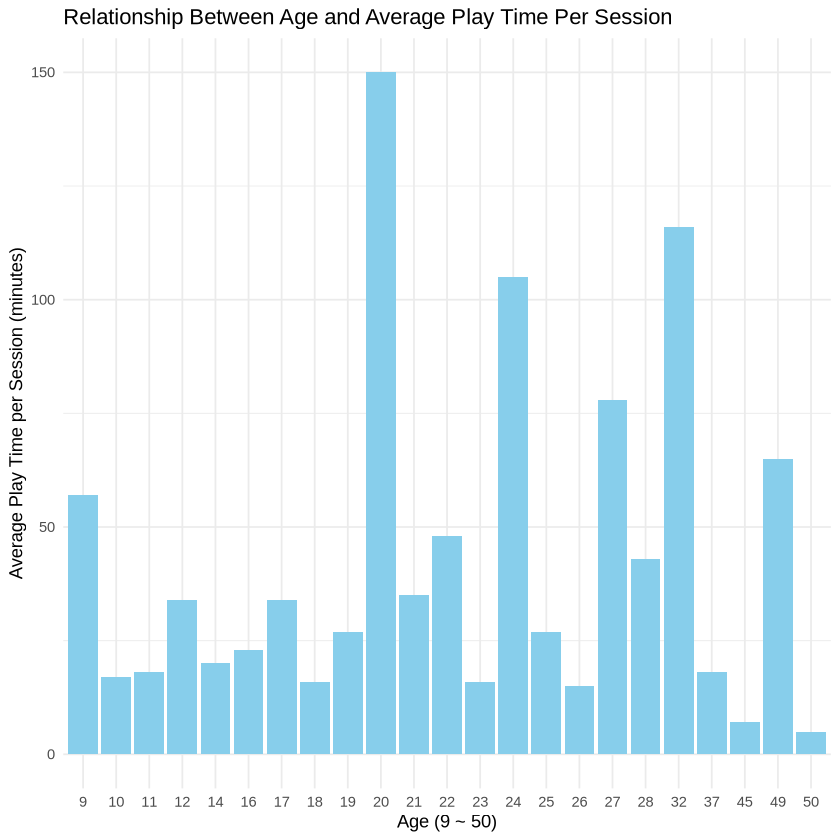

In [4]:
age_plot <- average_by_age |>
    ggplot(aes(x = factor(Age), y = average_playtime)) +
    geom_bar(stat = "identity", fill = "skyblue") + 
    labs(
        x = "Age (9 ~ 50)",
        y = "Average Play Time per Session (minutes)",
        title = "Relationship Between Age and Average Play Time Per Session"
    ) +
    theme_minimal() 

age_plot

In [5]:
merged_data2 <- merged_data2 |>
  mutate(age_group = case_when(
    Age >= 10 & Age < 20 ~ "10s",
    Age >= 20 & Age < 30 ~ "20s",
    Age >= 30 & Age < 40 ~ "30s",
    Age >= 40 & Age <= 59 ~ "40s~50s",
    TRUE ~ NA_character_
  ))

head(merged_data2,5)

grouped_playtime <- merged_data2 |>
  filter(!is.na(age_group)) |>
  group_by(age_group) |>
  summarize(avg_playtime = round(mean(average_playtime), 2))


Age,average_playtime,age_group
<int>,<dbl>,<chr>
9,57.28,NA
10,17.00,10s
11,18.00,10s
12,34.00,10s
14,30.14,10s


After grouping the data by age ranges (e.g., teens, 20s, 30s, etc.), ***I calculated the average playtime per session for each group.*** This allowed for a clearer comparison of gaming behavior across different age demographics.

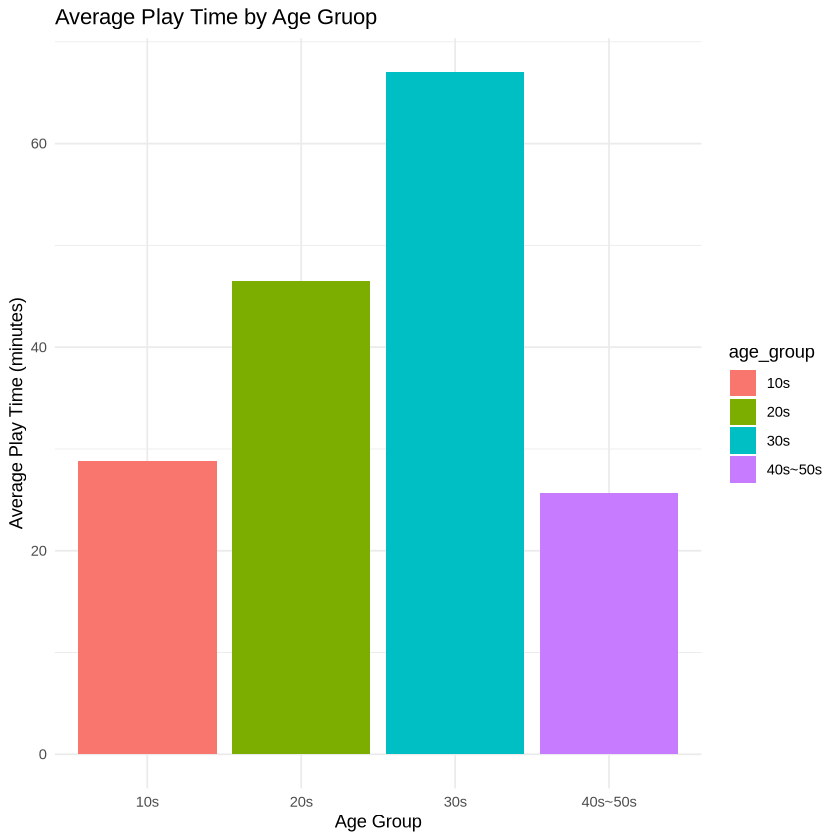

In [6]:
age_plot_by_group <- ggplot(grouped_playtime, aes(x = age_group, y = avg_playtime, fill = age_group)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Play Time by Age Gruop ",
       x = "Age Group",
       y = "Average Play Time (minutes)") +
  theme_minimal()

age_plot_by_group


## ***Question 1 result***

Based on the analysis of average playtime by age, **20-year-old players recorded the longest average playtime per session at 150 minutes**, followed by **32-year-olds (116 minutes)** and **24-year-olds (105 minutes)**. 

In contrast, **50-year-olds had the shorest average playtime per session at 5 minutes**, with **45 -year-olds (7 minutes)** and **26-year-olds (15 minutes)** also showing relatively short play durations. 

When grouped by age ranges, **players in their 30s had the highest average playtime per session**, followed by those in their **20s, teens (10s), and 40s~50s.** 

These results indicate that **players in their 20s and 30s tend to spend the most time per game session.**

## ***Q2. Do players with more experience tend to play more? (experience vs Avergae Played Hours)***

To analyze player engagement, I first cleaned and prepared the dataset by converting the experience, subscribe, and gender variables into categorical factors to ensure proper grouping. I also recoded the subscribe variable for clarity, renaming "TRUE" to "Subscribed" and "FALSE" to "Not Subscribed". Then, I grouped the data by experience level and calculated the average number of hours played within each group, excluding any missing values. To visualize this relationship, I created a ***bar plot*** using ggplot2, displaying average played hours on the y-axis and experience levels on the x-axis, with color-coded bars for each category. ***This plot provides a clear overview of how playtime varies with experience, offering insights into relation between "experience" and play time.***

In [7]:
# summary of the data set that is relevant for exploratory data analysis related to the planned analysis
tidy_player_dataset <- players |> 
    mutate(experience = as_factor(experience), 
           subscribe = as_factor(subscribe), 
           gender = as_factor(gender)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not Subscribed" = "FALSE"))

head(tidy_player_dataset, 5)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,Not Subscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,Subscribed,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,Subscribed,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


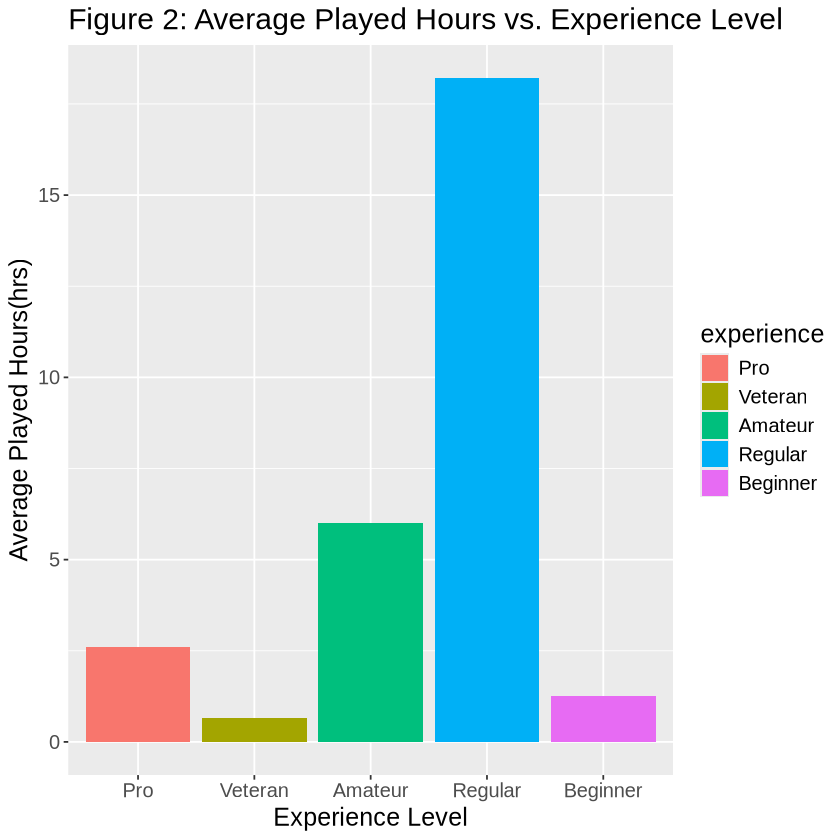

In [8]:
# visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
avg_played_hours <- tidy_player_dataset |>
  group_by(experience) |> 
  summarise(avg_hours = mean(played_hours, na.rm = TRUE))


experience_bar <- ggplot(avg_played_hours, aes(x = experience, y = avg_hours, fill = experience)) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 2: Average Played Hours vs. Experience Level",
       x = "Experience Level",
       y = "Average Played Hours(hrs)") +
  theme(text = element_text(size = 15))

experience_bar

## ***Question 2 Result***

Figure 2 shows that ***"Regular" players have the highest average playtime***, significantly exceeding all other experience levels. ***"Veteran" players have the lowest average playtime,*** suggesting that higher experience does not necessarily lead to greater engagement. "Pro" and "Amateur" players fall in the middle range, while "Beginner" players have the lowest playtime overall. ***This pattern indicates that e "Regular" players appear to be the most engaged.*** Therefore, ***we should recruit "Regular" players*** as they most likely to contribute a large amount of data (greater play time).

## ***Q3. Which gender has more sessions? (gender vs total sessions)***

gender,total_sessions
<chr>,<int>
Agender,11
Female,395
Male,1056
Non-binary,113
Other,1
Prefer not to say,24
Two-Spirited,6


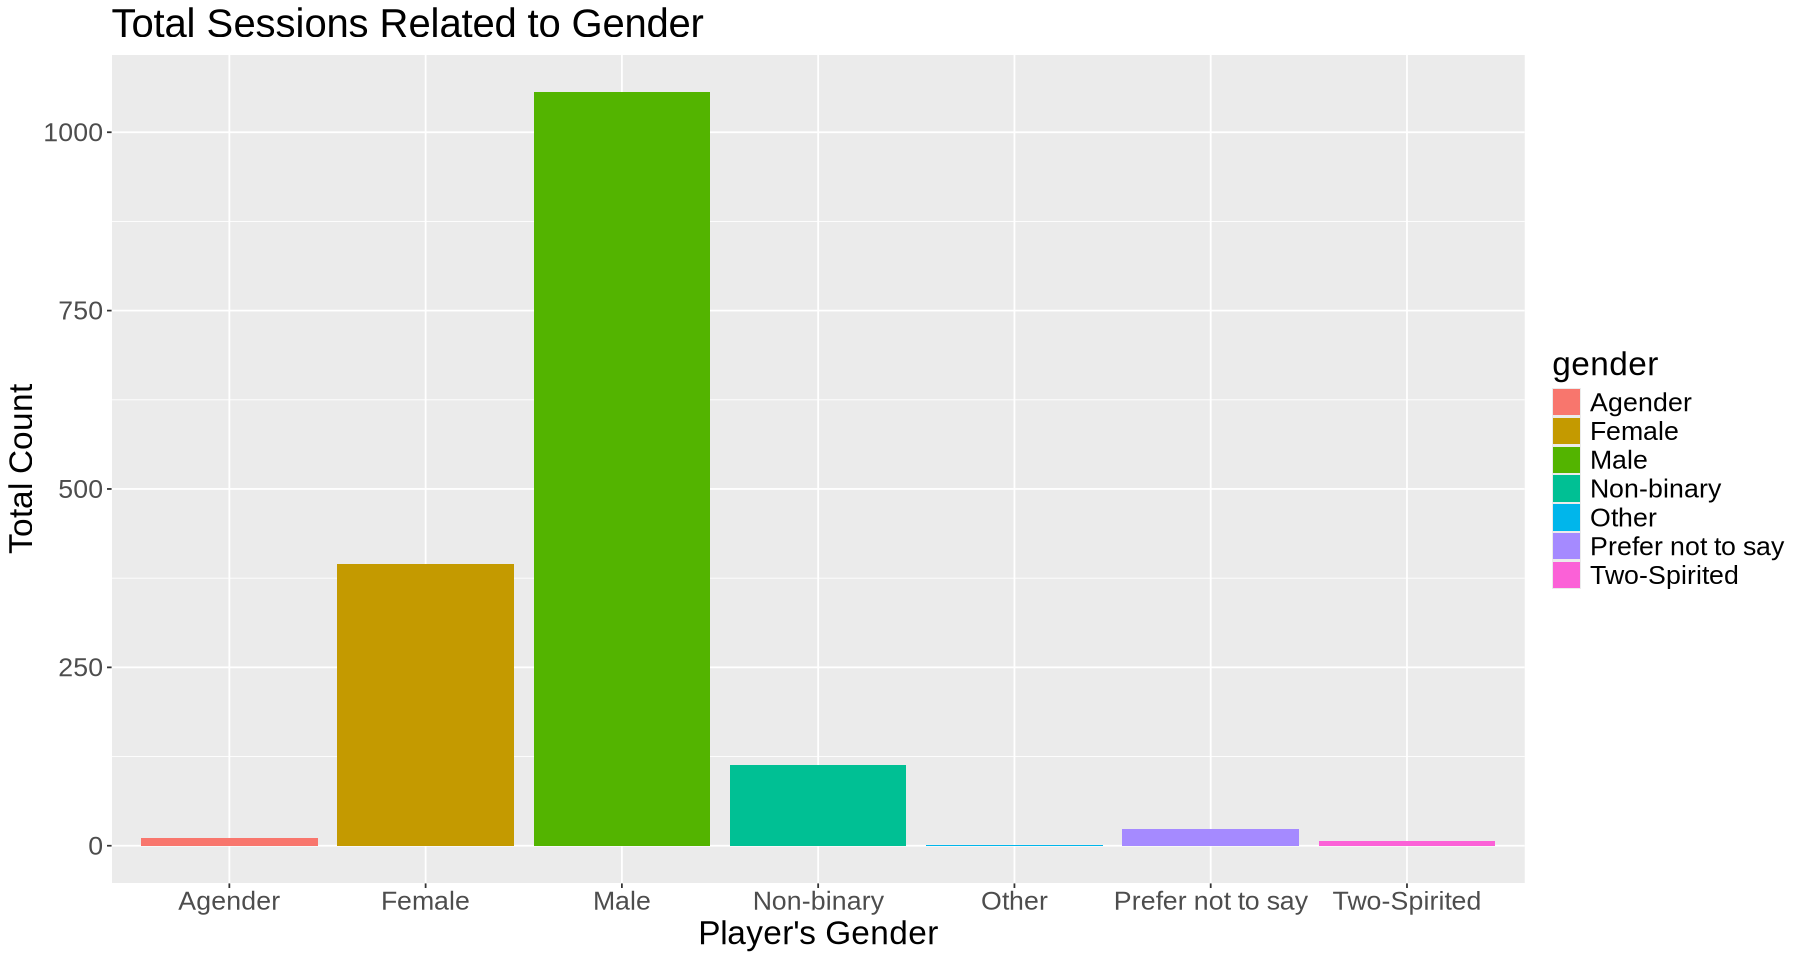

In [9]:
gender_sessions <- merged_data |>
filter(!is.na(gender)) |>
select(name, gender, start_time, end_time) |>
group_by(gender) |>
summarize(total_sessions=n()) 
gender_sessions

options(repr.plot.width = 15, repr.plot.height = 8)
gender_sessions_plot <- gender_sessions |>
ggplot(aes(x=gender, y=total_sessions, fill=gender)) +
geom_bar(stat="identity") +
labs(title="Total Sessions Related to Gender", x="Player's Gender", y="Total Count") +
theme(text = element_text(size=20))
gender_sessions_plot

**Steps**
1. Filter out rows with missing gender(NA) from gender column using `filter` function.
2. Select five column names (name, gender, start_time, end_time, session_duration) from data using `select` function.
3. Group the data by gender using `group_by` function.
4. Calculate total number of rows in sessions data for each gender using `summarize` function, then make a new name: total_sessions.
5. Print out gender_sessions.
6. Create a plot for relationship between gender and total sessions using gender_sessions data.
7. Using x = gender, y = total_sessions and fill gender to create a bar chart and create a title and each name of xlab and ylab using `labs` to combine it.

## ***Question 3 Result***

The bar shows the most, least and middle contributed for each genders. ***Male gender contributed most for this game*** which is in the upper 1000. ***Other gender contributed least for this game which is almost 0***. Besides, second place is Female, third place is Non-binary, fourth place is Prefer not to say, fifth place is Agender and sixth place is Two-Spirited. ***Therefore, we should recruit "Male platers" players as they most likely to contribute a large amount of data.***

## ***Q4. Do subscribers tend to play more than non-subscribers? (subscribe vs total play time)***

To examine the relationship between subscription status and player engagement, I began by grouping the cleaned dataset by the subscribe variable, which had been previously recoded for clarity ("Subscribed" and "Not Subscribed"). I then calculated the average number of hours played for each subscription group using the mean() function, excluding missing values with na.rm = TRUE. This step allowed me to quantify differences in playtime between subscribed and non-subscribed users. ***To visualize these differences, I created a bar plot***, with subscription status on the x-axis and average played hours on the y-axis. The bars were color-filled according to subscription status, and appropriate axis labels and a title were added to enhance readability. ***This plot helps reveal how subscription status is associated with average playtime, which, in turn, indicates the volume of gameplay data contributed by each group.***

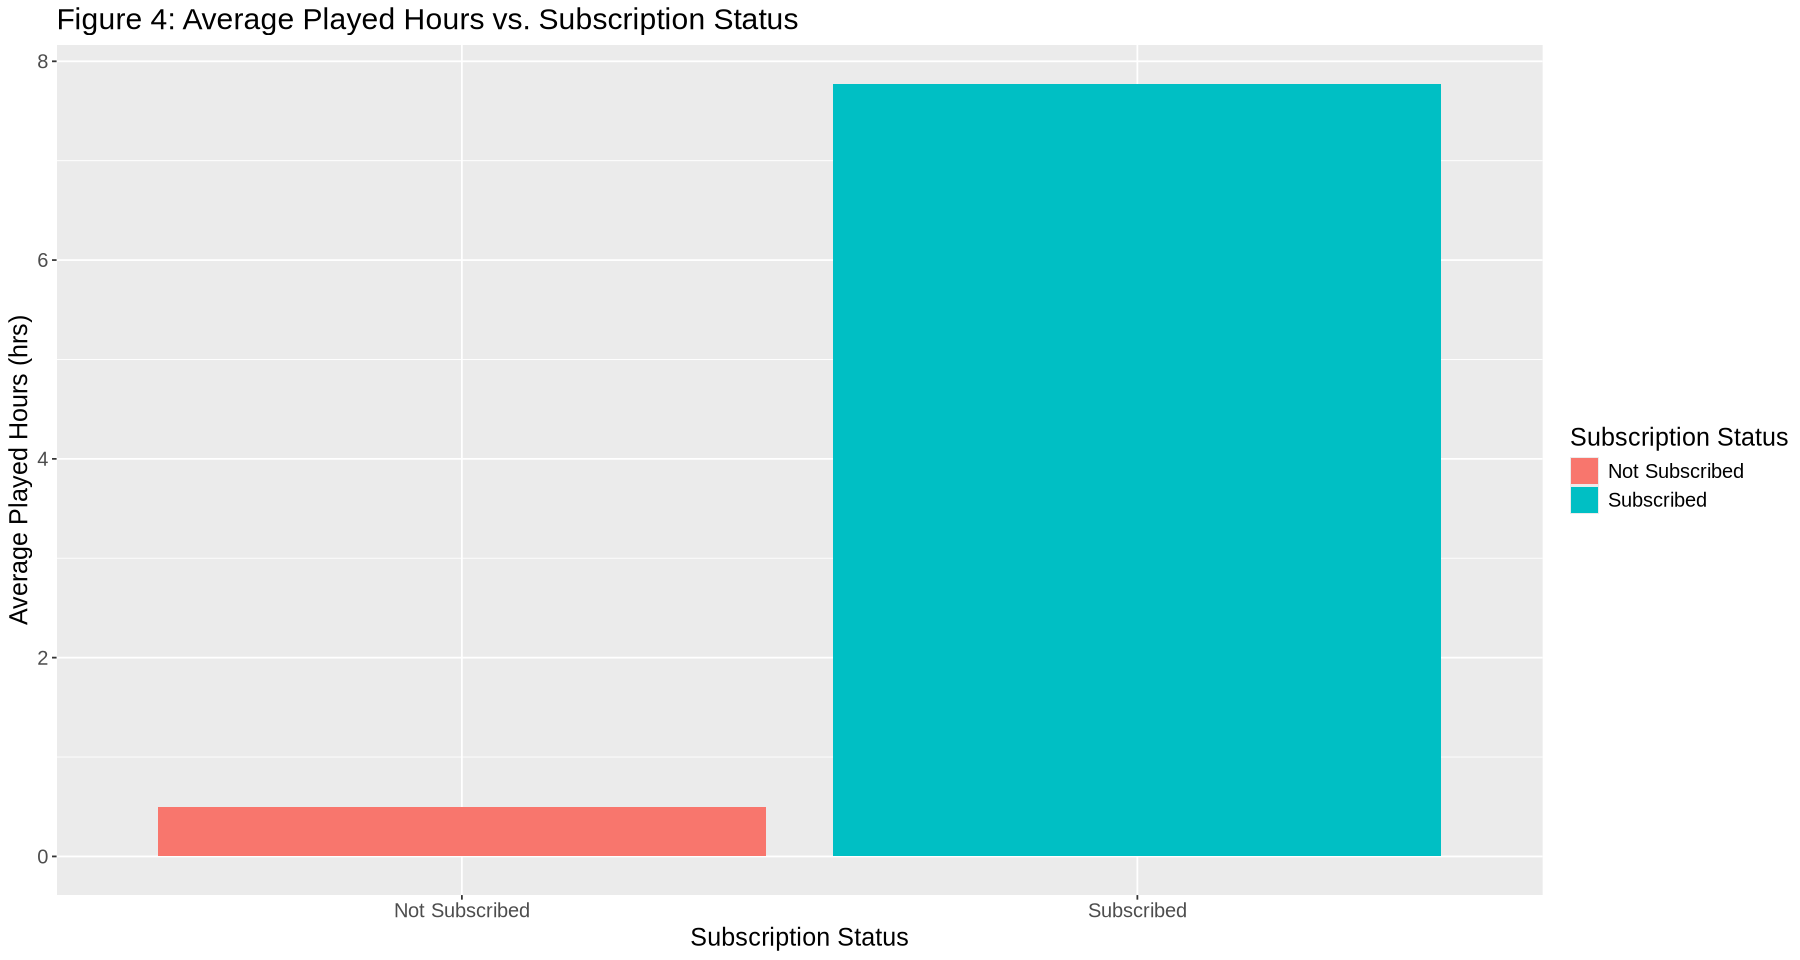

In [10]:
# Compute average played hours by subscription status
avg_played_hours_sub <- tidy_player_dataset |>
  group_by(subscribe) |>
  summarise(avg_hours = mean(played_hours, na.rm = TRUE)) 

# Create the bar plot
sub_bar <- ggplot(avg_played_hours_sub, aes(x = subscribe, y = avg_hours, fill = subscribe)) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 4: Average Played Hours vs. Subscription Status",
       x = "Subscription Status",
       y = "Average Played Hours (hrs)",
       fill = "Subscription Status") +
  theme(text = element_text(size = 15))
sub_bar

## ***Question 4 Result***

In figure 4, the comparison between subscribed and non-subscribed players demonstrates a clear and significant difference in playtime. ***Subscribed players spend singnificantly more time playing than non-subscribers, suggesting that subscribed players are most likely to contribute more to large amount of data.***

According to the diagram of the four small questions, ***players in 20 and 20 to 30 years old contributed the most to game time***, followed by players between 30 and 50 years old, and players with the shortest game time in 50 years and older. Compared to all other experience levels, the average player spends more time playing than the pro player averages on top of the game time. In terms of the impact of gender on the game, male gamers have contributed to the game for the longest time, even far more than other players. While some of the results are not far from the predicted, pros spend less time playing than the average gamer, suggesting that pro gamers are more focused on mastering the game than on the amount of time they spend playing. These findings provide suggestions and ideas for planning and adjusting the direction of the game, as well as studying user retention. ***Future developments can focus on how to adjust better decisions to make games accessible to different ages.***

# ***Conclusion*** #

Through our analysis, we found that certain types of player are strongly linked to higher engagement levels, which directly correlates with greater data contribution. ***Players in their 20s and 30s tend to spend the most time per session, suggesting that age influences how long players engage with the game at one session.*** Interestingly, while we expected more experienced players to play more, ***the data showed that "Regular" players had the highest overall playtime***, indicating they may be the most engaged group. In terms of gender, ****male players had the highest number of total sessions***, followed by female and non-binary players, meaning male players contributed the most session-based data. Also, we found that ***subscribed players played significantly more than non-subscribers***, confirming that subscription is a strong indicator of player engagement and data contribution.

***These findings mostly matched our expectations, especially for age and subscription***. However, the result that “Regular” players were more active than “Veteran” or “Pro” players was unexpected, suggesting that peak engagement may occur before players reach the most advanced levels. The impact of these findings is significant for game developers and marketing teams. By identifying which groups are most likely to generate large volumes of data, teams can better ***focus recruitment, personalization, and retention strategies.*** For example, ***promotional efforts might be more effective if targeted toward Regular, male, or subscribed players in their 20s and 30s.*** 

This analysis can also lead to several future questions:
> **1. What drives “Regular” players to engage more than others?**

> **2. Why do some experienced players reduce their playtime?**

> **3. Are there psychological or behavioral factors that explain differences in session duration by age?**

> **4. How do external factors like time availability, device preference, or game content updates affect engagement?**

Future developments can focus on how to adjust better decisions to make games accessible to different ages and other underrepresented groups effectively.
> **1. Designing targeted content for Regular players to sustain their momentum and encourage progression to more advanced levels.**

> **2. Personalized in-game recommendations or notifications based on player age, experience, and subscription status.**

> **3. Improving inclusivity by identifying barriers to engagement for non-binary players or underrepresented age groups, and addressing them through UI/UX or content adjustments.**

By expanding on these areas, developers and data teams can build more engaging and inclusive game environments, ultimately enhancing both user experience and data collection effectiveness.